#SongTron

In [1]:
"""
def binarize(image):
    #Binarizing image
    arr = image.flatten()
    mean = arr.mean()
    print("mean: {}".format(mean))

"""
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [14]:
def kernel_horizontal(bin_im):
    horizontal = np.copy(bin_im)
    rows = horizontal.shape[1]
    size = rows//30
    structure = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    print(structure)
    horizontal = cv2.erode(horizontal, structure)
    horizontal = cv2.dilate(horizontal, structure)
    return horizontal

def conv2d_image(f, w):
    N, M = f.shape[0:2]
    n, m = w.shape[0:2]
    w_flip = np.flip(np.flip(w, 0), 1)
    a = n//2  # floor of n/2
    b = m//2  # floor of m/2
    g = np.zeros(f.shape, dtype=np.float)
    for x in range(a, N-a):
        for y in range(b, M-b):
            region_f = f[x-a:x+(a+1), y-b:y+(b+1)]
            g[x][y] = np.sum(np.multiply(region_f.astype(np.float), w_flip.astype(np.float)))
    return g


def otsu_threshold(im):

    # Compute histogram and probabilities of each intensity level
    pixel_counts = [np.sum(im == i) for i in range(256)]
    n, m = im.shape[0:2]
    # Initialization
    s_max = (0,0)

    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)])\
                        / w_0 if w_0 > 0 else 0
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)])\
                        / w_1 if w_1 > 0 else 0

        # calculate - inter class variance
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2

        if s > s_max[1]:
            s_max = (threshold, s)
    return s_max[0]

def threshold(pic, threshold):
    return ((pic < threshold) * 255).astype('uint8')

### Image segmentation stuff

In [50]:
def distance(a, b):
    return np.abs(a-b)

def region_growing_average(img, img_t, tolerance, seed, region_n): 
    
    #img_t = np.zeros(img.shape)
    x = seed[0]; y = seed[1]

    img_t[x, y] = region_n
    
    avg = np.mean(img[np.where(img_t==region_n)])
    
    # check matrix border and conquering criterion for the 4-neigbourhood
    if (y+1 < img.shape[1] and img_t[x,y+1] == 0 and distance(avg, img[x, y+1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y+1], region_n)
        
    if (y-1 >= 0 and img_t[x,y-1] == 0  and distance(avg, img[x, y-1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y-1], region_n)
        
    if (x+1 < img.shape[0] and img_t[x+1,y] == 0  and distance(avg, img[x+1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x+1, y], region_n)
        
    if (x-1 >= 0 and img_t[x-1,y] == 0  and distance(avg, img[x-1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x-1, y], region_n)
        
def do_segmentation(image, thresh):
    segment_matrix = np.zeros(image.shape)
    region_counter = 1
    
    #Will check if region is above some treshold
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            pixel_val = image[x, y]
            if segment_matrix[x, y] == 0 and pixel_val >= thresh: #in case not assigned yet
                region_growing_average(image, segment_matrix, 10, (x, y), region_counter)
                region_counter += 1
                print("X: {} Y: {} Region: {}".format(x,y,region_counter))
    #print("Segmented regions: {}".format(region_counter))
    return segment_matrix
    

In [51]:
def main(filename):
    pic = imageio.imread(filename)
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.21 , 0.72, 0.07])

    plt.figure(figsize=(12,12))
    plt.title("Original")
    plt.imshow(pic, cmap='gray')
    plt.axis('off')
    
    bin_img = threshold(gray(pic), otsu_threshold(pic))
    plt.figure(figsize=(12,12))
    plt.title("Binarized")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')

    lines = kernel_horizontal(bin_img)
    plt.figure(figsize=(12,12))
    plt.title("Lines")
    plt.imshow(lines, cmap='gray')
    plt.axis('off')

    bin_img[lines == 255] = 0 
    plt.figure(figsize=(12,12))
    plt.title("Lines removed")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')
    """
    blurred = cv2.medianBlur(bin_img, 5)
    plt.figure(figsize=(12,12))
    plt.title("Blurred")
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')
    """
    kernel = np.ones((4,1),np.uint8)
    closing = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)

    plt.figure(figsize=(12,12))
    plt.title("Morphological Close")
    plt.imshow(closing, cmap='gray')
    plt.axis('off')

    segmented = do_segmentation(closing, otsu_threshold(pic))
    
    mask = np.zeros(segmented.shape)
    mask[segmented > 0] = 1
    
    plt.figure(figsize=(20,20))
    plt.title("Segmented")
    plt.imshow(segmented, cmap='magma')
    plt.axis('off')

    plt.figure(figsize=(20,20))
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    #Dilating image now...
    kernel_dilate = np.ones((3,3),np.uint8)
    dilated_mask = cv2.dilate(mask, kernel_dilate)
    
    plt.figure(figsize=(20,20))
    plt.title("Dilated mask")
    plt.imshow(dilated_mask, cmap='gray')
    plt.axis('off')
    
    plt.show()

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
X: 4 Y: 34 Region: 2
X: 10 Y: 78 Region: 3
X: 10 Y: 96 Region: 4
X: 20 Y: 43 Region: 5
X: 27 Y: 43 Region: 6
X: 55 Y: 37 Region: 7
X: 60 Y: 235 Region: 8
X: 60 Y: 326 Region: 9
X: 60 Y: 417 Region: 10
X: 74 Y: 5 Region: 11
X: 76 Y: 82 Region: 12
X: 76 Y: 493 Region: 13
X: 76 Y: 624 Region: 14
X: 76 Y: 715 Region: 15
X: 76 Y: 806 Region: 16
X: 76 Y: 882 Region: 17
X: 76 Y: 1179 Region: 18
X: 76 Y: 1187 Region: 19
X: 82 Y: 533 Region: 20
X: 91 Y: 1023 Region: 21
X: 105 Y: 139 Region: 22


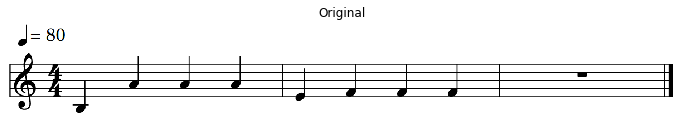

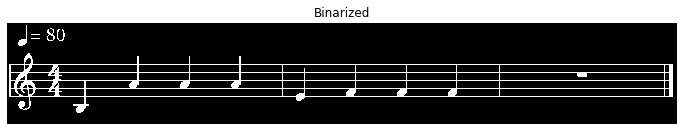

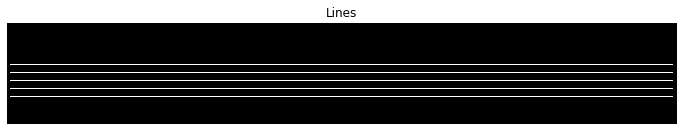

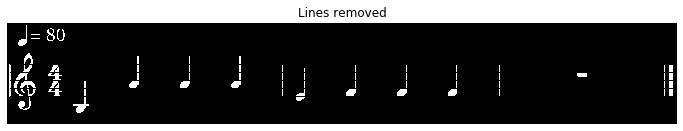

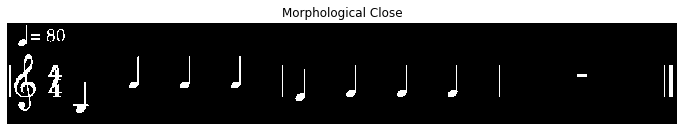

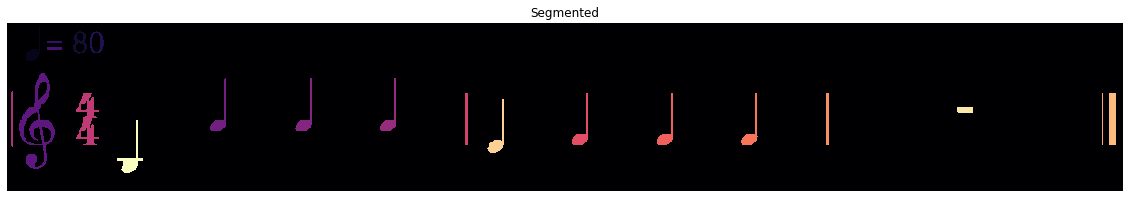

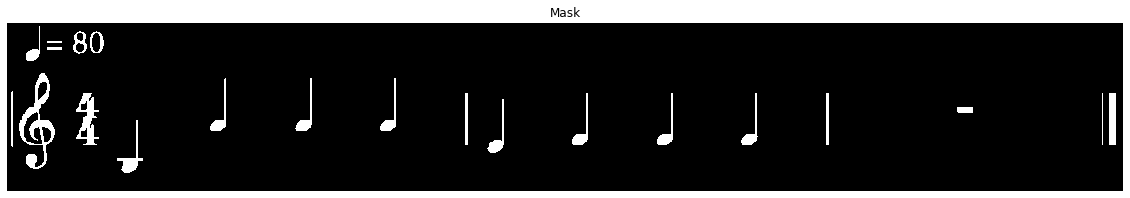

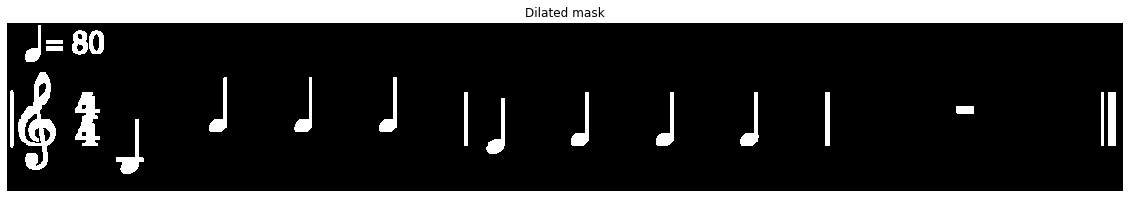

In [52]:
file1 = "../assets/songtron_test_0.png"
main(file1)    

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
Segmented regions: 131


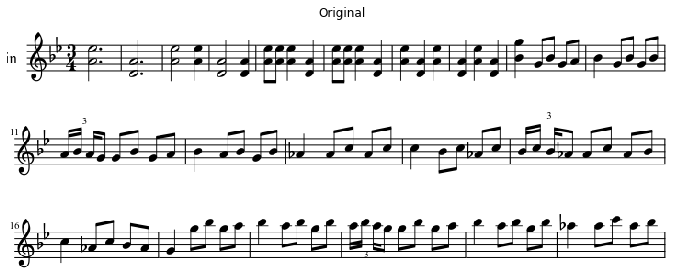

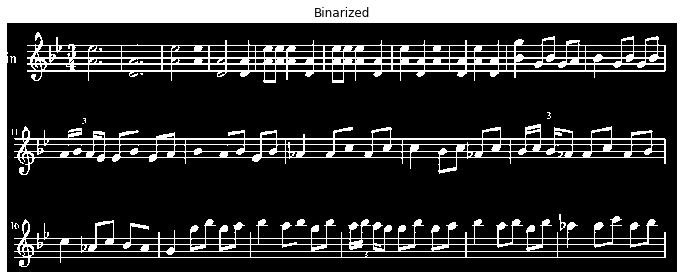

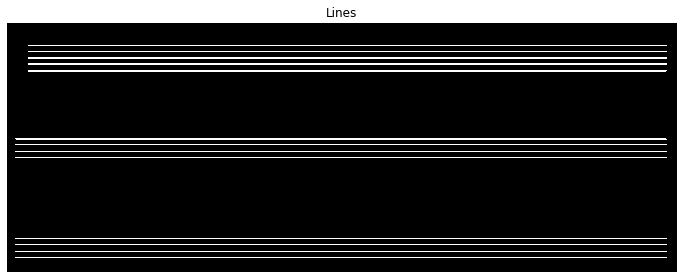

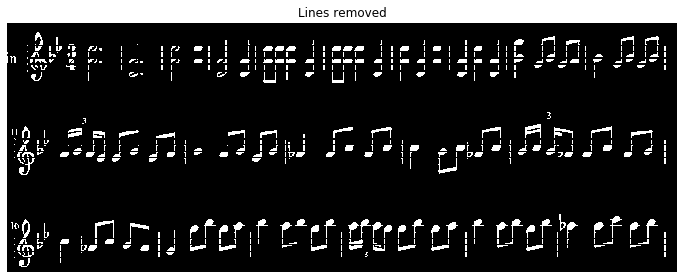

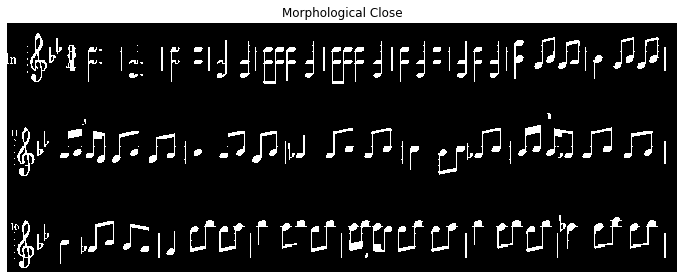

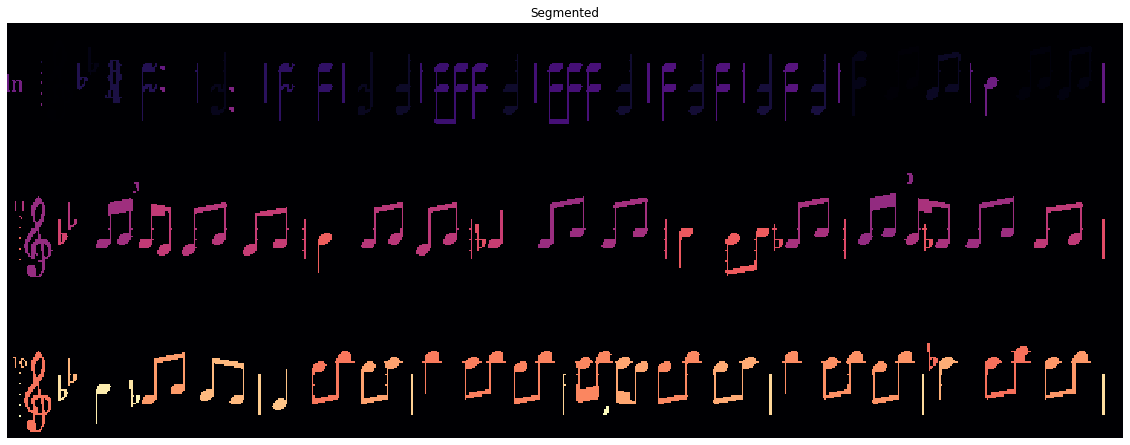

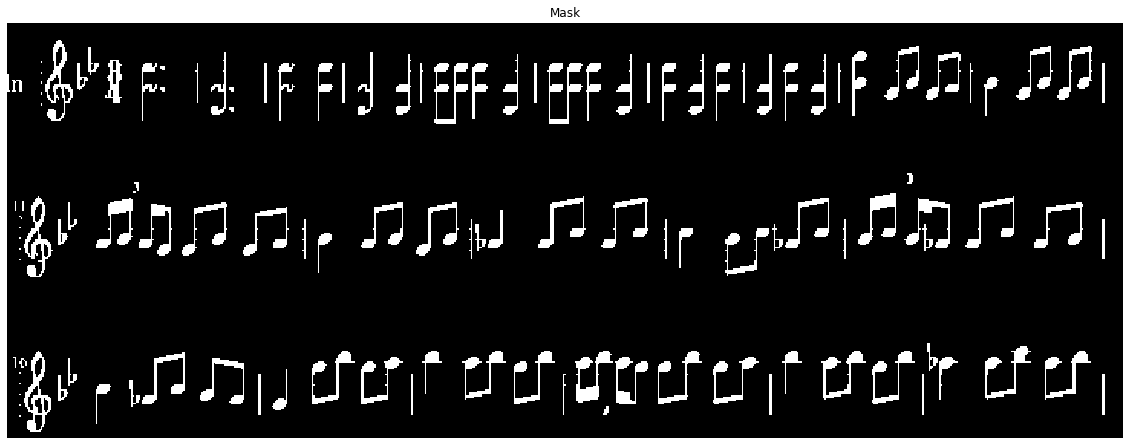

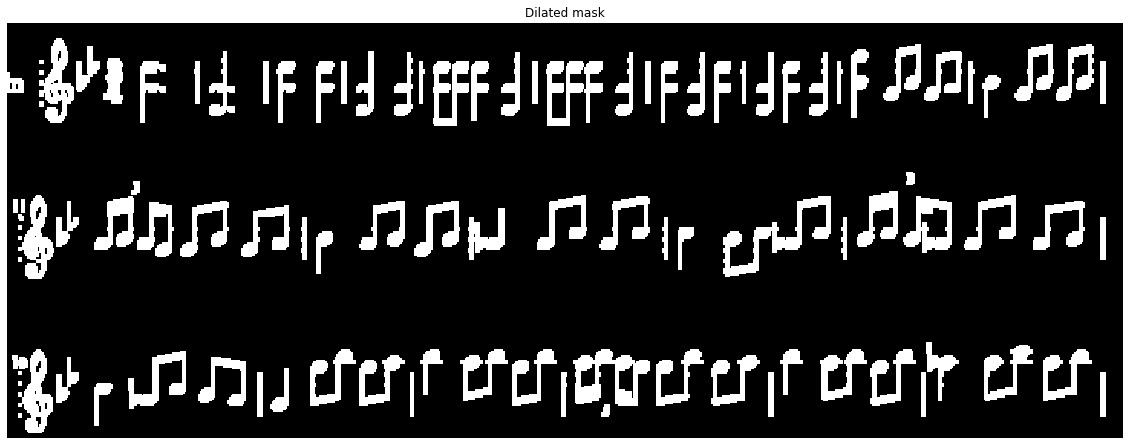

In [48]:
file2 = "../assets/danse_macabre_cut_0.png"
main(file2)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
Segmented regions: 101


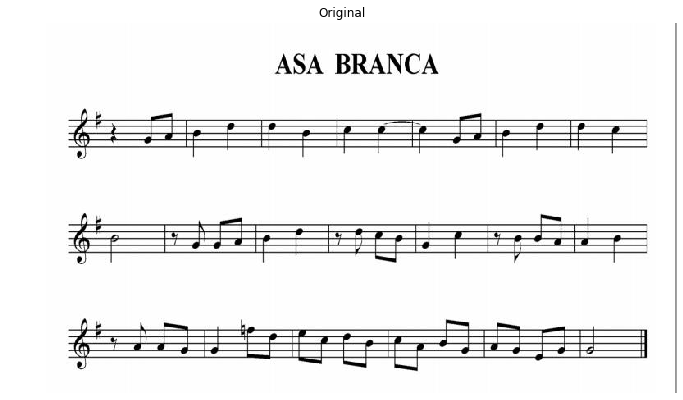

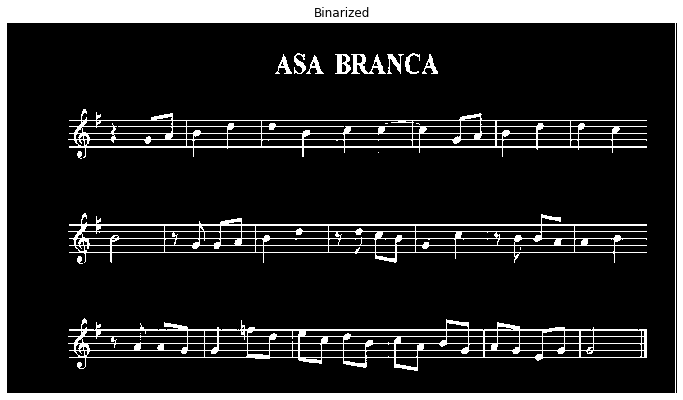

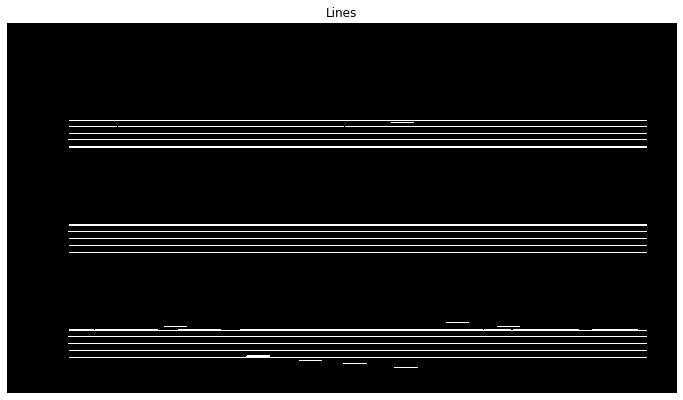

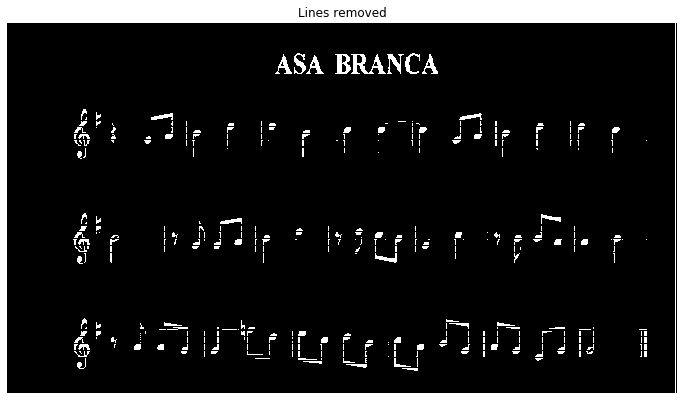

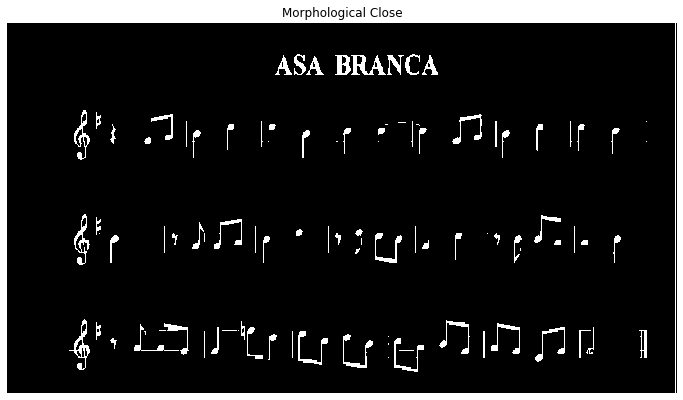

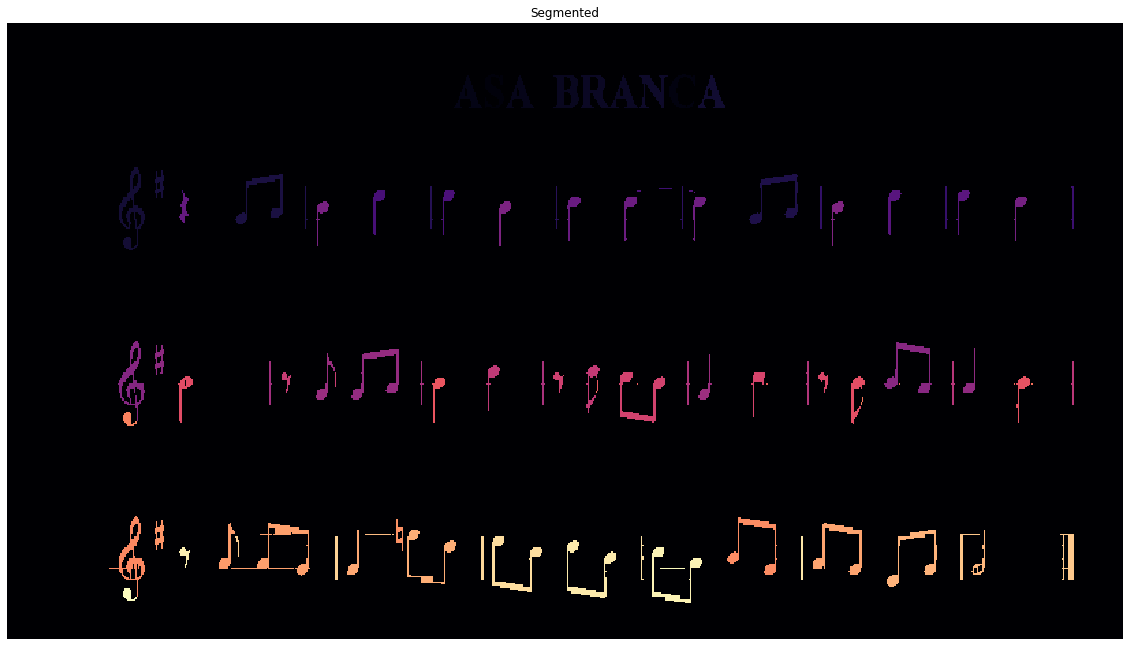

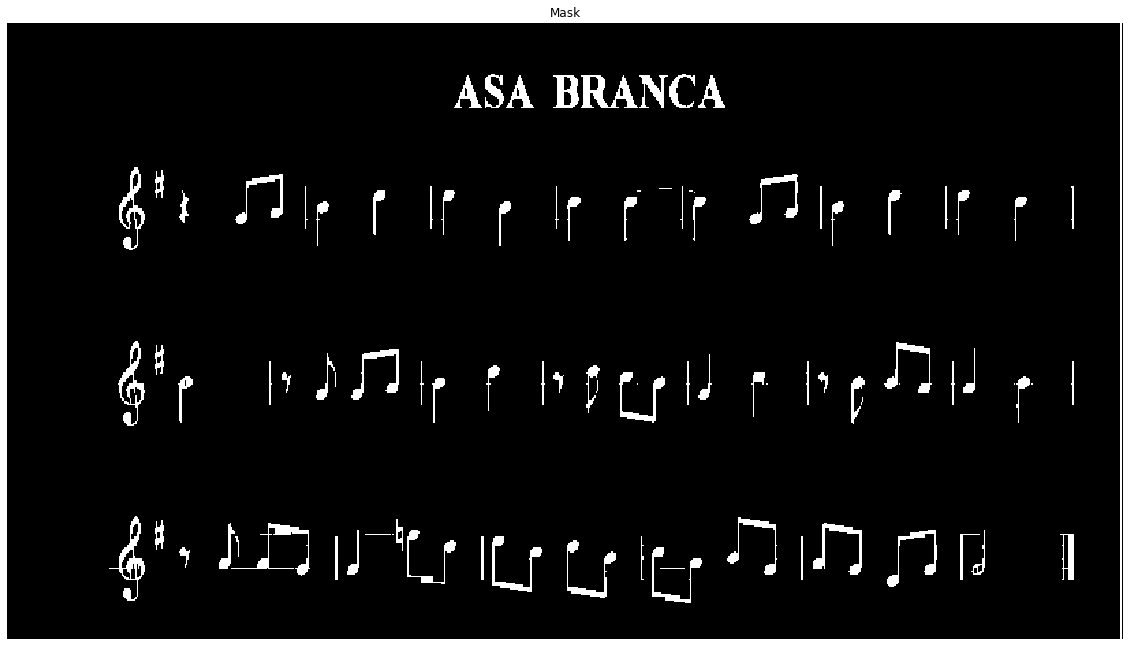

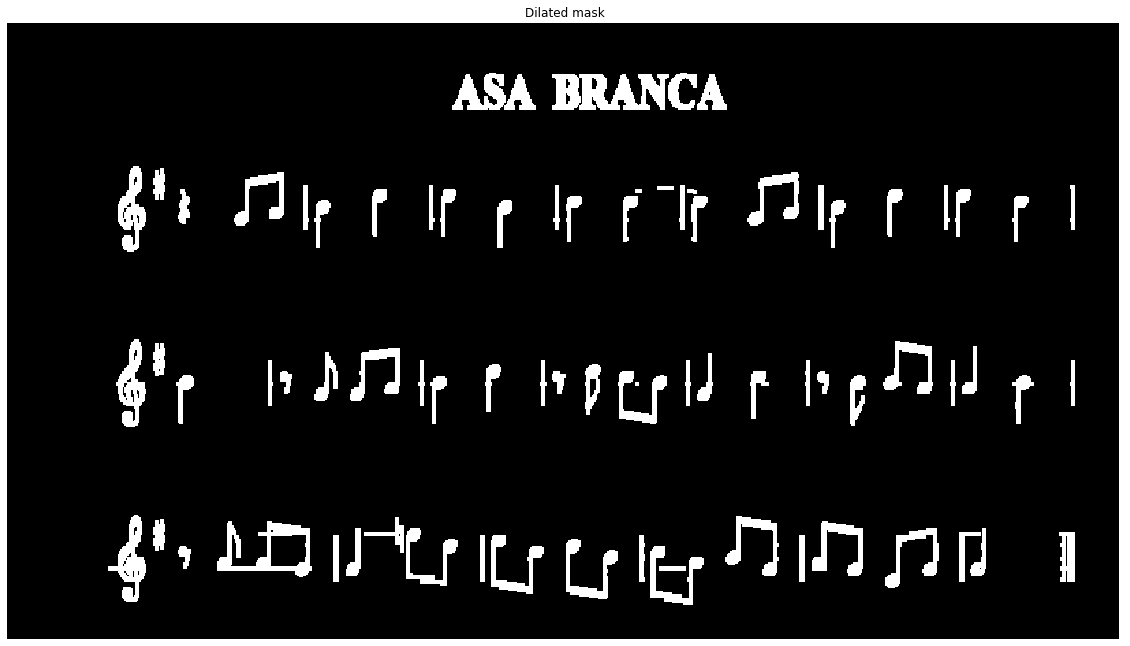

In [49]:
file3 = "../assets/asa_branca.jpg"
main(file3)